In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
import scipy

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
## update data
def filter_df(df):
    thresh=8
    age_counts = df.index.get_level_values('age').value_counts()
    ages_greater = list(age_counts[age_counts > thresh].index)
    return df.loc[df.index.get_level_values('age').isin(ages_greater)]

In [5]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [6]:
# prepare colors for plot
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
phasec = sns.color_palette("dana", n_colors=27)

/tmp/ipykernel_16807/2003451592.py:6: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana", cmap)


In [7]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
male_df=filter_df(male_df)
male_df = male_df.query('age<100')

In [8]:
long_df=male_df.copy()
# find first recording per week in the longtogeny dataset
from collections import defaultdict
ages = list(long_df.index.get_level_values('age').unique())
week_entries = defaultdict(list)
for age in ages:
    week, day = str(age).split('.')
    week_entries[week].append(age)

# Find the entry with the lowest day for each week
lowest_day_entries = [min(entries, key=lambda x: float(str(x).split('.')[1])) for entries in week_entries.values()]
long_df = long_df[long_df.index.get_level_values('age').isin(lowest_day_entries)]
long_df = long_df.rename_axis(index={'age': 'age_old'})
long_df['age'] = np.floor(long_df.index.get_level_values('age_old')).astype(int)
long_df.set_index('age',inplace=True, append=True)

In [9]:
# avarage per age or session
m_df= long_df.groupby(['age','uuid','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [10]:
m_data=m_df.copy()

In [11]:
fig=plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Entropy by age males", fontsize=10, y=0.95)
n=0
ages=[]
ent=[]

for age,_df in enumerate(m_data.groupby('age')):
    ages.extend(_df[1].index.get_level_values('age').to_numpy())
    data_temp = _df[1].to_numpy()
    arr = scipy.stats.entropy(data_temp, axis=1)
    ent.extend(arr)
    #ax = plt.subplot(7, 10, n + 1)
    #sns.barplot(data_temp, errorbar='se',ax=ax)
    #sns.lineplot(np.mean(data_temp, axis=0),ax=ax, color='#623f99')
    #ax.set_title('syllable usage ' + str(_df[1].index.get_level_values('age').unique().to_numpy()[0]))
    #ax.set_ylim(0,0.15)
    #ax.set_xticks([])
    #ax.set_ylabel('fraction of use')
    #n=n+1
    #sns.despine()

<Figure size 1200x1200 with 0 Axes>

In [12]:
#c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig4"/ 'long_entropy_examples.pdf')

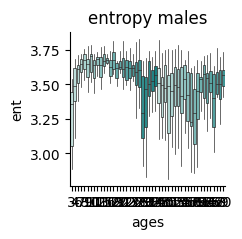

In [13]:
# plot entropy values
dfm=pd.DataFrame()
ages = [str(num) for num in ages]
dfm['ages']=ages
dfm['ent']=ent
dfm['sex'] = ['m'] * len(ages)
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=dfm, x=dfm.ages.astype('int'), y="ent",
             palette = phasec, 
            dodge=True, 
            showfliers=False, 
            linewidth=0.5, 
            showcaps=False,
           )
#sns.scatterplot(data=dfm, x="ages", y="ent",palette = phasec, alpha=0.50,s=10)
ax.set_title('entropy males')
#ax.set_ylim(3,3.5)
sns.despine()

In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'long_entropy_boxplots.pdf')

In [15]:
from scipy.stats import entropy
df=m_df.copy()

In [16]:
ent = pd.Series(entropy(df.to_numpy() + 1e-4, axis=1), index=df.index)
ent.name = 'entropy'

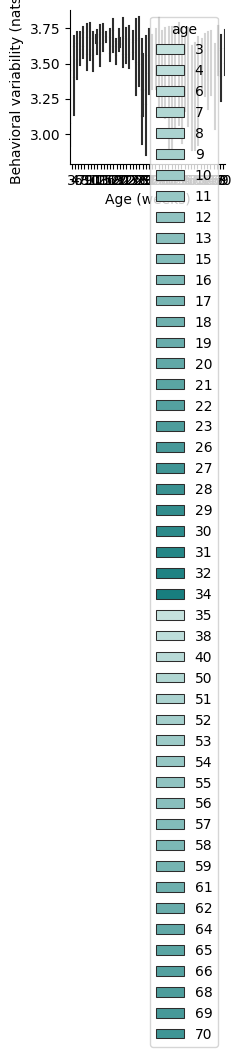

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
ax = sns.boxplot(
    data=ent.reset_index(),
    x="age",
    y="entropy",
    showfliers=False,
    showcaps=False,
    hue="age",
    palette=phasec,
)
ax.set(xlabel='Age (weeks)', ylabel='Behavioral variability (nats)')
sns.despine()

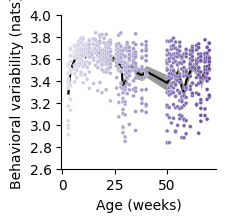

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
ax = sns.lineplot(
    data=ent.reset_index(),
    x="age",
    y="entropy",
    zorder=-1,
    color="black",
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)
ax = sns.scatterplot(
    data=ent.reset_index(),
    x="age",
    y="entropy",
    hue="age",
    palette=cmm,
    linewidths=0,
    s=8,
    legend=False,
)
ax.set(xlabel="Age (weeks)", ylabel="Behavioral variability (nats)", yticks = [2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0], ylim=[2.6,4.0])
sns.despine()

In [22]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'long_entropy_scatter.pdf')